# Implementation of transformers

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns


## 1. Self-Attention Mechanism


In [41]:
class SelfAttention(nn.Module):  # Computes attention scores and applies them to values
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embed size needs to be divisible by heads"
        # Linear transformations for keys, queries, and values
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

         # Reshape input tensors to work with multiple attention heads
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        # Compute attention scores (energy) using scaled dot-product attention
        energy = torch.einsum("nqhd,nkhd->nhqk", [query, keys])
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Apply softmax to get attention weights
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        # Multiply attention weights with values
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)  # Final linear transformation
        return out, attention


## 2. Transformer Components: Encoder & Decoder

In [43]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention, _ = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out


In [44]:
# Encoder: Processes the input sequence
class Encoder(nn.Module):
    def __init__(self, src_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length, device):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        self.layers = nn.ModuleList(
            [TransformerBlock(embed_size, heads, dropout, forward_expansion) for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        for layer in self.layers:
            out = layer(out, out, out, mask)
        return out

In [45]:
# Decoder: Generates output sequence based on encoder outputs
class Decoder(nn.Module):
    def __init__(self, trg_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length, device):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        self.layers = nn.ModuleList(
            [TransformerBlock(embed_size, heads, dropout, forward_expansion) for _ in range(num_layers)]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask): # Changed the parameters passed to the decoder's forward method
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        for layer in self.layers:
            # Pass x, enc_out, enc_out instead of x, enc_out, src_mask
            x = layer(x, enc_out, x, trg_mask) # call the layer with the corrected arguments
        return self.fc_out(x)

In [46]:
# Full Transformer Model: Combining Encoder & Decoder
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length, device):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length, device)
        self.decoder = Decoder(trg_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length, device)

    def forward(self, src, trg, src_mask=None, trg_mask=None):
        enc_out = self.encoder(src, src_mask)
        # Pass enc_out, enc_out, and trg instead of trg, enc_out, src_mask
        out = self.decoder(trg, enc_out, enc_out, trg_mask)
        return out

In [38]:
def plot_attention(attention, title="Attention Map"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention.cpu().detach().numpy(), cmap="Blues", annot=True)
    plt.title(title)
    plt.show()

def train_transformer(model, optimizer, criterion, src, trg):
    model.train()
    optimizer.zero_grad()

    # Ensure trg has correct shape by keeping full sequence
    output = model(src, trg)

    output = output.reshape(-1, output.shape[2])
    trg = trg.reshape(-1)  # Avoid shape mismatch

    loss = criterion(output, trg)
    loss.backward()
    optimizer.step()

    return loss.item()


Epoch 1, Loss: 2.4008
Epoch 2, Loss: 1.7990
Epoch 3, Loss: 2.0743
Epoch 4, Loss: 1.5881
Epoch 5, Loss: 1.2955


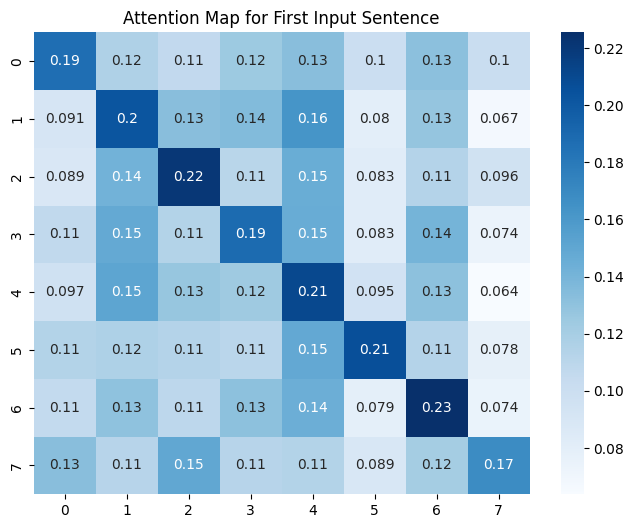

In [40]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Transformer(10, 10, 256, 6, 8, 4, 0.1, 100, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    src = torch.randint(0, 10, (2, 8)).to(device)
    trg = torch.randint(0, 10, (2, 8)).to(device)

    for epoch in range(5):
        loss = train_transformer(model, optimizer, criterion, src, trg)
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

    # Extract attention from the first self-attention layer of the first encoder block
    with torch.no_grad():
        enc_out = model.encoder(src, None)
        first_layer = model.encoder.layers[0].attention
        _, attention = first_layer(enc_out, enc_out, enc_out, None)

        # Plot the attention map for the first input sentence
        plot_attention(attention[0][0].cpu(), title="Attention Map for First Input Sentence")
